<a href="https://colab.research.google.com/github/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/EAST_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook relies on this PyImageSearch blog post [OpenCV Text Detection (EAST text detector)](https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/) to convert a pre-trained EAST model to TFLite.

From the blog post:
> The EAST pipeline is capable of predicting words and lines of text at arbitrary orientations on 720p images, and furthermore, can run at 13 FPS, according to the authors.

EAST was proposed in [An Efficient and Accurate Scene Text Detector](https://arxiv.org/abs/1704.03155). 

## Setup

In [ ]:
!pip install tf-nightly

In [2]:
import tensorflow as tf
tf.__version__

'2.4.0-dev20200723'

## Executing the code from the blog post

We will be first executing the original codebase to just have a test of the results. 

In [ ]:
!wget http://t.dripemail2.com/c/eyJhY2NvdW50X2lkIjoiNDc2ODQyOSIsImRlbGl2ZXJ5X2lkIjoiYnFoc2xnandzMWtteWw5M3NkeTAiLCJ1cmwiOiJodHRwOi8vcHlpbWcuY28vZHM1c2k_X19zPXp3a2NncTN3aG5oemhleDJ1ZHJmIn0\

In [ ]:
!unzip eyJhY2NvdW50X2lkIjoiNDc2ODQyOSIsImRlbGl2ZXJ5X2lkIjoiYnFoc2xnandzMWtteWw5M3NkeTAiLCJ1cmwiOiJodHRwOi8vcHlpbWcuY28vZHM1c2k_X19zPXp3a2NncTN3aG5oemhleDJ1ZHJmIn0

In [7]:
!python /content/opencv-text-detection/text_detection.py --image /content/opencv-text-detection/images/lebron_james.jpg \
	--east /content/opencv-text-detection/frozen_east_text_detection.pb

[INFO] loading EAST text detector...
(1, 1, 80, 80) (1, 5, 80, 80)
[INFO] text detection took 0.710104 seconds


Be sure to comment out the last two lines of `text_detection.py` script and add `cv2.imwrite("image.png", orig)`. After you are done executing the script see the result by opening "image.png". 

## TFLite model conversion

In [72]:
#@title 
quantization = "float16" #@param ["dynamic_range", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='/content/opencv-text-detection/frozen_east_text_detection.pb', 
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3']
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

From the blog post:

```
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
```

In [73]:
open('east_model_{}.tflite'.format(quantization), 'wb').write(tflite_model)

48155456

In [74]:
!ls -lh east_model_float16.tflite

-rw-r--r-- 1 root root 46M Jul 23 12:34 east_model_float16.tflite


In [36]:
!ls -lh /content/opencv-text-detection/frozen_east_text_detection.pb

-rw-r--r-- 1 root root 93M Apr 24  2018 /content/opencv-text-detection/frozen_east_text_detection.pb


## Inference

In [37]:
from imutils.object_detection import non_max_suppression
import numpy as np
import time
import cv2

### Prepare an input image

In [61]:
# load the input image and grab the image dimensions
image = cv2.imread("/content/opencv-text-detection/images/lebron_james.jpg")
orig = image.copy()
(H, W) = image.shape[:2]
print(H, W)

500 600


In [62]:
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)

In [63]:
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]
print(H, W)

320 320


In [64]:
# convert the image to a floating point data type and perform mean
# subtraction
image = image.astype("float32")
mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
image -= mean
image = np.expand_dims(image, 0)

### Perform inference

In [65]:
interpreter = tf.lite.Interpreter(model_path='east_model_float16.tflite')
input_details = interpreter.get_input_details()
interpreter.resize_tensor_input(0, [1, image.shape[1], image.shape[2], 3]) 
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image)
start = time.time()
interpreter.invoke()
print(f"Inference took: {time.time()-start} seconds")

Inference took: 1.0132322311401367 seconds


In [66]:
# Investigate the output
interpreter.get_output_details()

[{'dtype': numpy.float32,
  'index': 245,
  'name': 'feature_fusion/Conv_7/Sigmoid',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 80, 80,  1], dtype=int32),
  'shape_signature': array([-1, -1, -1,  1], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 253,
  'name': 'feature_fusion/concat_3',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 80, 80,  5], dtype=int32),
  'shape_signature': array([-1, -1, -1,  5], dtype=int32),
  'sparsity_parameters': {}}]

In [67]:
# Parse the outputs
scores = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()
geometry = interpreter.tensor(
    interpreter.get_output_details()[1]['index'])()

In [68]:
# We need to have this shape:  (1, 1, 80, 80) (1, 5, 80, 80)
scores.shape, geometry.shape 

((1, 80, 80, 1), (1, 80, 80, 5))

In [69]:
scores = np.transpose(scores, (0, 3, 1, 2)) 
geometry = np.transpose(geometry, (0, 3, 1, 2))

## Processing the inference results

Note that majority of the following section comes from the blog post I mentioned at the beginning. 

In [70]:
from google.colab.patches import cv2_imshow

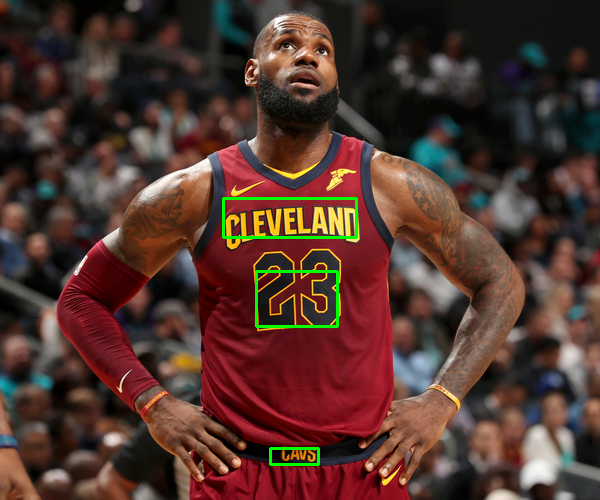

In [71]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < 0.5:
			continue

		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)

		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2_imshow(orig)